<a href="https://colab.research.google.com/github/yecatstevir/teambrainiac/blob/main/SingleSubjectSVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Whole Brain Support Vector Machine Training
- Go to 'Runtime' in Colab browser bar, select 'Change Runtime Type', select 'High-RAM' from 'Runtime Shape'. 
- load local pickle file containing all masked, normalized Whole Brain subject data in numpy matrix format
- SVM training all subjects
- SVM training per subject

### Mount Google Drive and clone repository
- open to source directory

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')#, force_remount = True)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Clone the entire repo.
!git clone -l -s https://github.com/yecatstevir/teambrainiac.git
# Change directory into cloned repo
%cd teambrainiac/source
!ls


fatal: destination path 'teambrainiac' already exists and is not an empty directory.
/content/teambrainiac/source/teambrainiac/source
Access_Load_Data.ipynb		  Mat_to_Numpy.ipynb
All_subject_masked_labeled.ipynb  models
cross_validation.py		  path_config.py
data				  percent_signal_change.ipynb
Explore_data.ipynb		  process.py
explore.py			  SVM_Group_Child_Whole_Brain.ipynb
Images				  SVM_Group_YA_Whole_brain.ipynb
__init__.py			  utils.py
Masking.ipynb			  Visualize_Data.ipynb


### Load path_config.py 
- we are already in source so we can just load this file without chanding directory

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving path_config.py to path_config (1).py
User uploaded file "path_config.py" with length 228 bytes


### Load the Whole brain normalized masked all subject 2d pickle file 
- go to Drive outside of this notebook
  - create a folder named data
  - upload 'whole_brain_all_norm_2d.pkl' - will take 5 hours but should remain on system without need to upload again
  - once uploaded, drag the file to the repo source/data directory

In [ ]:
!ls

 Access_Load_Data.ipynb		   'path_config (2).py'
 All_subject_masked_labeled.ipynb  'path_config (3).py'
 cross_validation.py		    path_config.py
 data				    percent_signal_change.ipynb
 Explore_data.ipynb		    process.py
 explore.py			    __pycache__
 Images				    SVM_Group_Child_Whole_Brain.ipynb
 __init__.py			    SVM_Group_YA_Whole_brain.ipynb
 Masking.ipynb			    teambrainiac
 Mat_to_Numpy.ipynb		    utils.py
 models				    Visualize_Data.ipynb
'path_config (1).py'


### Import libraries


In [ ]:

# Import libraries
!pip install boto3 nilearn nibabel
from sklearn.model_selection import GridSearchCV
import pickle
from utils import data_to_nib, load_mat, open_pickle, access_load_data, save_data, create_mask, labels_mask_binary, masking_data, masked_data_n_labels
from sklearn.svm import SVC
import numpy as np
import pandas as pd
import random
import cv2 as cv

### Load Data from AWS and create Train/Val/Test splits

In [ ]:
%%time
pkl_file = "whole_brain_all_norm_2d.pkl" # normalized
pkl_file_all = 'all_data_dictionary.pkl' #Unnormalized
bool_mat = False
data = access_load_data(pkl_file, bool_mat)
data_unnorm = access_load_data(pkl_file_all,bool_mat)

CPU times: user 1min 31s, sys: 1min 57s, total: 3min 29s
Wall time: 3min 53s


In [ ]:
#open path dictionary file to get subject ids
path = "data/data_path_dictionary.pkl"
data_path_dict = open_pickle(path)
subject_ids = data_path_dict['subject_ID']

# # Randomly shuffle ids for train test val splits
# random.seed(42)
# random.shuffle(subject_ids)

In [ ]:
mask_data_path = data_path_dict['mask_data'][0]
mask_type_dict = access_load_data(mask_data_path,True)
np_array_mask = mask_type_dict['mask']

In [ ]:
indices_mask = np.where(np_array_mask==1)
indices_mask

(array([ 3,  3,  3, ..., 75, 75, 75]),
 array([36, 36, 36, ..., 47, 47, 47]),
 array([33, 34, 35, ..., 28, 29, 30]))

In [ ]:
from utils import *
import numpy as np
from sklearn.preprocessing import StandardScaler
def scale_data_single_subj(sub_data,sub_labels, runs_train,runs_test,norm):
  """
    data         : (1 subject data, keys as subject ID for frmi data or labels)
    runs_train   : tuple , (which run are we using for the training data)
    runs_test    : tuple, (which run are we using for the test data)
    norm         : string, ("RUNS": normalizing separately on each run;
                            "SUBJECT": Normalizing separately by each subject)
    returns      : nd.arrays, Concatenated X data of (time points, x*y*z) x = 79, y = 95, z = 75
                   and Concatenated y labels of (time points,)
    """

    # train and labels
  X = []
  y = []
  ##val and labels
  Xv = []
  yv = []
  # TEST and labels
  Xt = []
  yt = []
  if len(runs_train)>1:
      for run in runs_train:
        X.append(sub_data[run])
        y.append(sub_labels[run])
      
      X = np.concatenate(np.array(X))
      y = np.concatenate(np.array(y))
  else:
      X = sub_data[runs_train[0]-1]
      y = sub_labels[runs_train[0]-1]
  if len(runs_test)> 1:
      Xv = sub_data[runs_test[0]-1]
      yv = sub_labels[runs_test[0]-1]
      Xt = sub_data[runs_test[1]-1]
      yt = sub_labels[runs_test[1]-1]
  else:
      Xt = sub_data[runs_test[0]-1]
      yt = sub_labels[runs_test[0]-1]
  if norm == "RUNS":
      scalar = StandardScaler()
      X = scalar.fit_transform(X)

      scalarT = StandardScaler()
      Xt = scalarT.fit_transform(Xt)
      if len(Xv)>0:
        Xv = scalarT.fit_transform(Xv)
  elif norm == "SUBJECT":
      #print(f"Normalizing Each Subject Data for group {group_sub_ids}")
      scalar = StandardScaler().fit(X)
      X = scalar.transform(X)
      

      Xt = scalar.transform(Xt)
      if len(Xv)>0:
        Xv = scalar.transform(Xv)
  else:
      print('Not doing standardization')      
  return X, y, Xt, yt, Xv, yv

In [ ]:
from sklearn.metrics import accuracy_score
def run_all_single_subject_svm(subject_ids,data,datatype,runs_train,runs_test,norm="none"):
  subj_acc = []
  for subj in subject_ids:
    sub_data = data[subj]
    sub_labels = data[f"{subj}_rt_labels"]
    if norm!="none":
      X_train, y_train, X_test, y_test, X_val, y_val = scale_data_single_subj(sub_data,sub_labels,runs_train,runs_test,norm)
    else:
      X_train = sub_data[1]
      y_train = sub_labels[1]
      X_val = sub_data[2]
      y_val = sub_labels[2]
      X_test = sub_data[3]
      y_test = sub_labels[3]
    clf = SVC()
    clf.fit(X_train,y_train)
    train_predicts = clf.predict(X_train)
    if len(X_val)>0:
      y_val_predicts = clf.predict(X_val)
      val_acc = accuracy_score(y_val,y_val_predicts)
    else:
      y_val_predicts = 0
      val_acc = 0
    y_test_predicts = clf.predict(X_test)
    tr_acc = accuracy_score(y_train,train_predicts)   
    test_acc = accuracy_score(y_test,y_test_predicts)
    subj_list = [subj,tr_acc,val_acc,test_acc,norm,datatype]
    subj_acc.append(subj_list)
  return subj_acc,X_train, y_train, X_test, y_test, X_val, y_val,

In [ ]:
def run_single_subject_svm(sub_data,sub_labels,runs_train,runs_test,norm="none"):
  if norm!="none":
    X_train, y_train, X_test, y_test, X_val, y_val = scale_data_single_subj(sub_data,sub_labels,runs_train,runs_test,norm)
  else:
    X_train = sub_data[1]
    y_train = sub_labels[1]
    X_val = sub_data[2]
    y_val = sub_labels[2]
    X_test = sub_data[3]
    y_test = sub_labels[3]
  clf = SVC()
  clf.fit(X_train,y_train)

  return clf,X_train,y_train,X_test,y_test,X_val,y_val

In [ ]:
#from scipy._lib.six import X
def run_model(subject_ids, model_dict, runs_train,runs_test,norm='none'):
  for subj in subject_ids:
  #subj = subject_ids[0]
    sub_data = data[subj]
    sub_labels = data[f"{subj}_rt_labels"]
    clf,X_train, y_train, X_test, y_test, X_val, y_val = run_single_subject_svm(sub_data,sub_labels,runs_train,runs_test,norm)
    #train_predicts = clf.predict(X_train)  
    model_dict[subj] = {}
    model_dict[subj]['model'] = clf
    model_dict[subj]['X_train'] = X_train
    model_dict[subj]['y_train'] = y_train
    model_dict[subj]['X_test'] = X_test
    model_dict[subj]['y_test'] = y_test
    if len(X_val)>0:
      model_dict[subj]['X_val'] = X_val
      model_dict[subj]['y_val'] = y_val
  return model_dict
  # alphas = np.zeros((len(X_train)))
  # alphas[clf.support_] = clf.dual_coef_
  # alphas = alphas.reshape(1,-1)
  # bmap = np.dot(alphas,X_train)
  # bmap2 = np.zeros((79,95,79))
  # bmap2[indices_mask] = bmap
  

In [ ]:
#model_dict = {}
sub_ids = subject_ids[10:20]
model_dict_two_runs_train = run_model(sub_ids,model_dict_two_runs_train,(2,3),(4,),norm="RUNS")

NameError: ignored

In [ ]:
from sklearn.metrics import accuracy_score
def get_accuracy_scores(model_dict):
  for subj in subject_ids:
    #subj_data = model_dict[subj]
    clf = model_dict[subj]['model']
    X_train = model_dict[subj]['X_train']
    y_train = model_dict[subj]['y_train']
    X_test = model_dict[subj]['X_test'] 
    y_test = model_dict[subj]['y_test']
    if 'X_val' in model_dict[subj].keys():
      X_val = model_dict[subj]['X_val']
      y_val = model_dict[subj]['y_val']
      y_val_predicts = clf.predict(X_val)
      val_acc = accuracy_score(y_val,y_val_predicts)
    else:
      y_val_predicts = 0
      val_acc = 0
    train_predicts = clf.predict(X_train) 
    y_test_predicts = clf.predict(X_test)
    tr_acc = accuracy_score(y_train,train_predicts)   
    test_acc = accuracy_score(y_test,y_test_predicts)
    subj_list = [subj,tr_acc,val_acc,test_acc,'RUNS','PSCNORM']
    subj_acc.append(subj_list)
  return subj_acc

In [ ]:
import pickle
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
path = "/content/drive/My Drive/data/model_dict_one_run_train.pkl"
model_dict = {}
model_dict_one_run_train = run_model(subject_ids,model_dict,(2,),(3,4),norm="RUNS")
# f = open(path, "wb")
# pickle.dump(model_dict_one_run_train, f)
# f.close()
# single_run_acc_scores = get_accuracy_scores(model_dict)

Mounted at /content/drive


NameError: ignored

In [ ]:
single_run_acc_scores_pd = pd.DataFrame(single_run_acc_scores
                                        ,columns=["Subject","TrainAcc","ValAcc","TestAcc","NormBy","DataType"])


In [ ]:
subj_acc_tuned = subj_acc
subj_acc_tuned_pd = pd.DataFrame(subj_acc_tuned,columns=["Subject","TrainAcc","ValAcc","TestAcc"])

In [ ]:
subj_acc_tuned_pd.describe()

,TrainAcc,ValAcc,TestAcc
count,52.0,52.000000,52.000000
mean,1.0,0.622940,0.572573
std,0.0,0.124361,0.110482
min,1.0,0.345238,0.297619
25%,1.0,0.535714,0.500000
50%,1.0,0.625000,0.553571
75%,1.0,0.672619,0.642857
max,1.0,0.892857,0.809524


In [ ]:
subj_acc_unnorm = subj_acc
subj_acc_unnorm_pd = pd.DataFrame(subj_acc_unnorm,columns=["Subject","TrainAcc","ValAcc","TestAcc"])

In [ ]:
subj_acc_unnorm_pd.describe()

,TrainAcc,ValAcc,TestAcc
count,52.000000,52.000000,52.000000
mean,0.822573,0.569139,0.533425
std,0.123746,0.096111,0.062686
min,0.547619,0.464286,0.464286
25%,0.723214,0.500000,0.500000
50%,0.821429,0.529762,0.505952
75%,0.940476,0.601190,0.559524
max,1.000000,0.869048,0.785714


In [ ]:
sub_data = data[train_ids]
sub_labels = data[f"{train_ids}_rt_labels"]
X_train = sub_data[1]
y_train = sub_labels[1]
X_val = sub_data[2]
y_val = sub_labels[2]
X_test = sub_data[3]
y_test = sub_labels[3]

In [ ]:
c_params = {'C':[0.7, 1, 5, 10],  'random_state':[111,222],'kernel':['linear', 'rbf']}
svc = SVC()
clf = GridSearchCV(svc, c_params)
clf.fit(X_train, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.7, 1, 5, 10], 'kernel': ['linear', 'rbf'],
                         'random_state': [111, 222]})

In [ ]:
clf.cv_results_

{'mean_fit_time': array([0.44343896, 0.43571653, 0.46810989, 0.44078774, 0.44791121,
        0.43250356, 0.44005427, 0.45443754, 0.49297438, 0.4456212 ,
        0.46652431, 0.78583884, 0.49999266, 0.46750994, 0.4745194 ,
        0.4928463 ]),
 'mean_score_time': array([0.07163687, 0.0615231 , 0.71420207, 0.71203556, 0.06107469,
        0.06131248, 0.66369467, 0.72052937, 0.06586089, 0.05683522,
        0.65238104, 0.84305472, 0.07154489, 0.07770882, 0.64263291,
        0.65166111]),
 'mean_test_score': array([0.71470588, 0.71470588, 0.64117647, 0.64117647, 0.71470588,
        0.71470588, 0.65367647, 0.65367647, 0.71470588, 0.71470588,
        0.67720588, 0.67720588, 0.71470588, 0.71470588, 0.65367647,
        0.65367647]),
 'param_C': masked_array(data=[0.7, 0.7, 0.7, 0.7, 1, 1, 1, 1, 5, 5, 5, 5, 10, 10, 10,
                    10],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False, False, False, False, False],
  

In [ ]:
#4 runs * 52 subjects = 208
print(f"length of Xtrain data: {len(X_train)} and length of ytrain data: {len(y_train)}")
print(f"length of Xval data: {len(X_val)} and length of yval data: {len(y_val)}")
print(f"length of Xtest data: {len(X_test)} and length of ytest data: {len(y_test)}")
#print(f"length of X data: {len(X)} and length of y data: {len(y)}")

In [ ]:
%%time
X_train = np.array(X_train)
y_train = np.array(y_train)
print( "Xtrain data shape ", X_train.shape)
print( "ytrain data shape ", y_train.shape)


## Set up SVM Model

#### SKlearn model

In [ ]:
%%time
clf_d = SVC()
clf_d.fit(X_train, y_train)

CPU times: user 2.8 s, sys: 1.35 s, total: 4.15 s
Wall time: 740 ms


In [ ]:
train_predicts = clf_d.predict(X_train)

In [ ]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_train,train_predicts))

0.9047619047619048


In [ ]:
clf.dual_coef_

array([[-1.        , -1.        , -1.        , -1.        , -0.74011177,
        -0.97927558, -1.        , -1.        , -1.        , -1.        ,
        -0.95415499, -1.        , -1.        , -1.        , -0.81801869,
        -0.139726  , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -0.20745497, -1.        , -1.        , -0.71515448,
        -1.        , -1.        , -0.19619546, -0.59197146, -0.27050794,
        -1.        , -1.        , -1.        , -0.93654786, -0.72847896,
        -0.29723958, -0.94735151, -1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  0.99162816,
         1.        ,  1.        ,  1.        ,  0.08156754,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  0.65494326,  1. 

In [ ]:
y_val_predicts = clf.predict(X_val)
y_test_predicts = clf.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_val,y_val_predicts))
print(accuracy_score(y_test,y_test_predicts))

0.6428571428571429
0.7857142857142857


In [ ]:
alphas = np.zeros((84))
alphas[clf.support_] = clf.dual_coef_
alphas = alphas.reshape(1,-1)
bmap = np.dot(alphas,X_train)
bmap2 = np.zeros((79,95,79))
bmap2[indices_mask] = bmap

In [ ]:
bmap2 = np.zeros((79,95,79))
bmap2[indices_mask] = bmap

In [ ]:
bmap_unweighted = np.zero

#### OpenCV library
- https://docs.opencv.org/3.4/d1/d73/tutorial_introduction_to_svm.html


In [ ]:
%%time

# Train the SVM using openCV
svm = cv.ml.SVM_create()
svm.setType(cv.ml.SVM_C_SVC)
svm.setKernel(cv.ml.SVM_LINEAR)
svm.setTermCriteria((cv.TERM_CRITERIA_MAX_ITER, 100, 1e-6))
svm.train(X_train, cv.ml.ROW_SAMPLE, y_train)


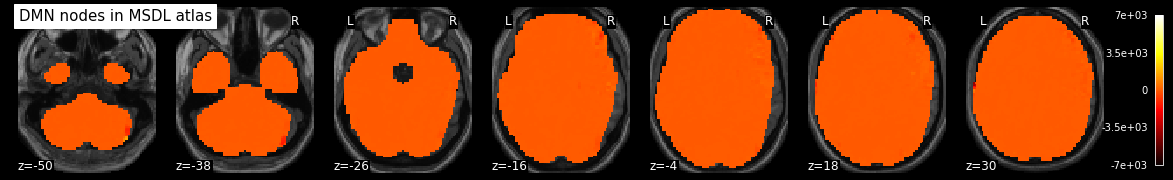

In [ ]:
from nilearn import plotting, image
display = plotting.plot_stat_map('/content/drive/My Drive/data/bmap3.nii', bg_img = '/content/drive/My Drive/data/single_subj_T1_resampled.nii',
                                 colorbar=True, cmap='hot', display_mode='z',
                                 title="DMN nodes in MSDL atlas")

In [ ]:
def explore_4d_img(layer):
    plt.figure(figsize = (10, 5))
    plt.imshow(img_4d[:, :, layer, time_point], cmap = 'gray')
    plt.title("Layers of the brain")
    plt.axis('off')
    return layer

# Call interactive component of function above at time point 139 
interact(explore_4d_img, layer = (0, img_4d.shape[2] - 1))
plt.show()

IndexError: ignored

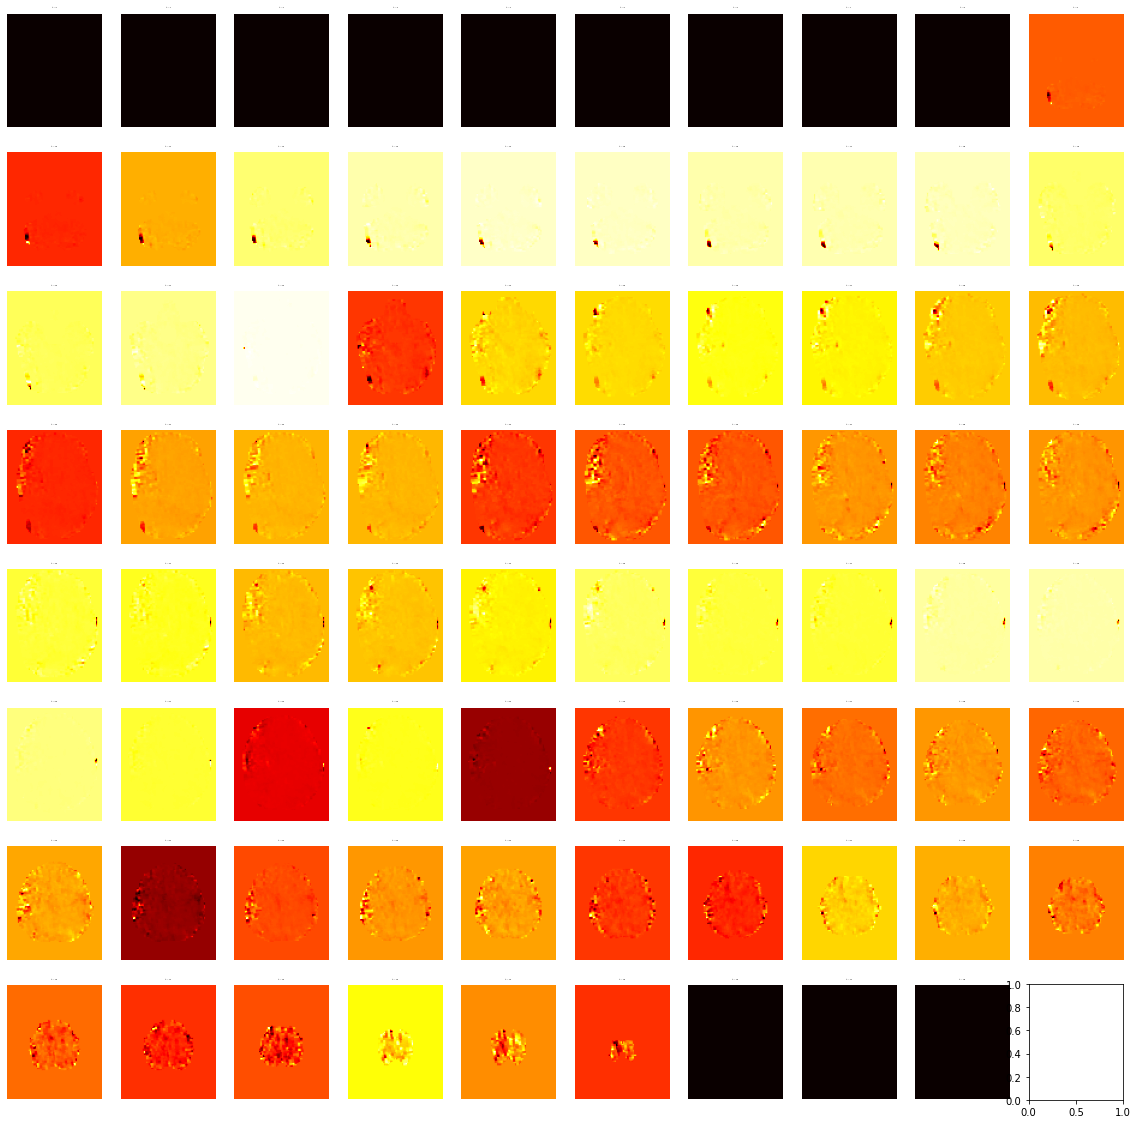

In [ ]:
from matplotlib import patches
import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols=10, nrows=8, figsize=(20, 20))  # 20 timepoints
# Loop over the first 20 volumes/timepoints
for t, ax in enumerate(axes.flatten()):    
    ax.imshow(bmap2[:, :, t].T, cmap='hot', origin='lower')  # index with t!
    #rect = patches.Rectangle((38, 20), 2, 2, linewidth=2, edgecolor='r', facecolor='black')
    #ax.add_patch(rect)
    ax.axis('off')
    ax.set_title('t = %i' % t, fontsize=2)
fig.tight_layout()

In [ ]:
bmap2[0,0,0]

In [ ]:
plt.imshow(bmap2.get_fdata()[:,:,50])

NameError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import nibabel as nib
image = nib.load('/content/drive/My Drive/data/w3rtprun_01.nii')

In [ ]:
img_data = image.get_fdata()
print(type(img_data))  # it's a numpy array!
print(img_data.shape)

<class 'numpy.memmap'>
(79, 95, 79, 144)


In [ ]:
bmap3 = nib.Nifti1Image(bmap2,affine=image.affine)
nib.save(bmap3, '/content/drive/My Drive/data/bmap3.nii')
# x_train = nib.Nifti1Image(X_train,affine=image.affine)
# nib.save(x_train,'/content/drive/My Drive/data/x_train.nii')

In [ ]:
image.affine